<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Assignment 1</h1>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">
Commit your solutions to our 
<a href='https://classroom.github.com/a/kezCqKON'>GitHub Classroom</a>
until May 3, 23:59</h4>
</div>
<br>

## Part 1
## Correlation of Future Orientation Index and Gross Domestic Product

### Tasks

In this exercise, we try to reproduce the findings of the article “Quantifying the Advantage of Looking Forward” http://www.nature.com/articles/srep00350.

According to the study, the GDP per capita of countries is positively correlated to how much their population searches in Google for the next year, relative to how much they search for the previous year.

This ratio is called the Future Orientation Index (FOI). So for example for the year 2017 the FOI can be calculated as: FOI = number of searches for the term “2018” / number of searches for the term “2016”.

You will do the following tasks:
1. Aquire World Bank Data
2. Calculate the Future Orientation Index in Google Trends
3. Test the correlation between GDP and FOI

### Install requirements

The following cell contains all the necessary dependencies needed for this task. If you run the cell everything will be installed.  
* [`wbgapi`](https://github.com/tgherzog/wbgapi) is a Python package which provides modern, pythonic access to the World Bank's data API. [Here](https://github.com/tgherzog/wbgapi) is the documentation of `wbgapi`.
* [`pandas`](https://pandas.pydata.org/docs/index.html) is a Python package for creating and working with tabular data. [Here](https://pandas.pydata.org/docs/reference/index.html) is the documentation of `pandas`.
* [`matplotlib`](https://matplotlib.org/) is a Python package for creating plots. [Here](https://matplotlib.org/stable/api/index.html) is the documentation of `matplotlib`.
* [`scipy`](https://scipy.org/) is a Python package with different algorithms for scientific computing. [Here](https://docs.scipy.org/doc/scipy/reference/index.html#scipy-api) is the documentation of `scipy`.

In [9]:
! pip install wbgapi
! pip install pandas
! pip install matplotlib
! pip install scipy
! pip install pycountry

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Exercise 1: World Bank Data *(3 points)*
#### 1.1 Download WDI data

From the WDI we need three indicators:
* Gross Domestic Product (GDP) per capita corrected by the Purchase Power Parity (PPP in current or 2005 international $, `"NY.GDP.PCAP.PP.KD"`)
* The amount of Internet users (per 100 people, `"IT.NET.USER.ZS"`
* The total population (described as as "Population, Total", `"SP.POP.TOTL"`)

In the following code chunk, download all data (including extras) for all countries in year 2014 and save it as a pandas data frame. See [here](https://github.com/tgherzog/wbgapi#accessing-data) how to use the `data` subpackage of `wbgapi`.

Hint: To remove aggregates (economic regions defined by the World Bank) and include only countries, use `skipAggs=True`.

In [4]:
import wbgapi as wb
WDIdf = wb.data.DataFrame(['NY.GDP.PCAP.PP.KD', 'IT.NET.USER.ZS', "SP.POP.TOTL"], time = range(2014, 2015, 1), skipAggs = True, labels = True)

Now drop any row that has `NaN` for this you can use `pandas` [`dropna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) method.

In [5]:
import pandas as pd
WDIdf.dropna()

,Country,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL
economy,,,,
ZWE,Zimbabwe,16.36474,2316.954536,13855753.0
ZMB,Zambia,6.50000,3375.941270,15737793.0
PSE,West Bank and Gaza,53.67000,5967.073437,4173398.0
VNM,Vietnam,41.00000,7641.909252,91235504.0
VUT,Vanuatu,18.80000,2917.627300,269927.0
...,...,...,...,...
ATG,Antigua and Barbuda,67.78000,18779.480712,89236.0
AGO,Angola,21.40000,8183.678371,27128337.0
DZA,Algeria,29.50000,11561.259795,38760168.0


Next only keep rows where there are at least 5 Million internet users. Keep in Mind that the Internet Users are per 100 people, so don't forget to take the population into account.

For example in the dataset Austria has 80.995825 internet users per 100 people, while 8546356 people living in Austria. This means Austria has 6922191.55 internet users in total. The calculation for that is as follows:
<br>

$$
\begin{align}
internet\_users = population \cdot \frac{internet\_user\_per\_100}{100}
\end{align}
$$


In [6]:
#rename the columns for convenience 
WDIdf.rename(columns={'SP.POP.TOTL': 'tot_pop', 'IT.NET.USER.ZS': 'int_user_100', 'NY.GDP.PCAP.PP.KD' : 'gdp_cap_pp'}, inplace=True)
#dropna added as it didn't get rid of all of them the first time for whatever reason, filtered for 5M internet users
reduced_WDIdf = WDIdf[(WDIdf.tot_pop * WDIdf.int_user_100 / 100) > 5000000].dropna()
reduced_WDIdf

,Country,int_user_100,gdp_cap_pp,tot_pop
economy,,,,
VNM,Vietnam,41.000000,7641.909252,91235504.0
UZB,Uzbekistan,35.500000,6075.192224,30757700.0
USA,United States,73.000000,57308.318417,318386329.0
GBR,United Kingdom,91.610000,44247.029670,64602298.0
ARE,United Arab Emirates,90.400000,64334.091552,8835951.0
...,...,...,...,...
AUT,Austria,80.995825,52932.900112,8546356.0
AUS,Australia,84.000000,47240.274464,23475686.0
ARG,Argentina,64.700000,23550.099060,42669500.0


### Exercise 2: The Future Orientation Index in Google Trends *(3 points)*
#### 2.1 Download data from Google Trends

You can download the data from Google Trends following these steps:

1) Log out from your google account or set its language to English

2) Go to trends.google.com and search for 2013 

3) Add 2015 as a search term

4) Select custom time rage: full year: 2014

5) Set the region to “Worldwide”. You can also try with this link (it links to the google trends page with all settings from above applied): https://trends.google.com/trends/explore?date=2014-01-01%202014-12-31&q=2013,2015

6) Go to the map at “Compared breakdown by region” and tick on “include low search volume regions”

7) On the top right menu click the download button to get a geoMap.csv file

Load the .csv file in a pandas data frame. Notice in the file the first 3 Lines are actually only information (while the third is the header). You can skip these lines by using `skiprows=3` in `pd.read_csv`. Set the headers to `"Country", "G2013", "G2015"`, this can be done by the keyword argument `names` in `pd.read_csv`.

Now remove again all rows containing `NaN`.

All the percentage data is saved as a string containing the `%` symbol. You can remove this with `pandas` [`str.replace`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.replace.html) method and save them as integer with `pandas` [`astype`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html) method. Do this for column `G2013` and `G2015`.


In [7]:
# read csv, skipping the first three rows, renaming the columns accordingly, drop NA values, remove percentage signs, and change the percentage columns to integers
g_trends = ((pd.read_csv("geoMap.csv", skiprows = 3, names = ["Country", "G2013", "G2015"])).dropna()).replace("%", "", regex = True).astype({"G2013":"int", "G2015":"int"})


#### 2.2 Calculate the Future Orientation Index

In the following code chunk, make a new column in the Google Trends dataframe with the Future Orientation Index, which is the ratio between the search volume for 2015 and 2013 in 2014 for each country

In [8]:
g_trends["FOI"] = g_trends.G2015 / g_trends.G2013

#### 2.3 Merge with World Bank data

Merge the WDI and google trends data frames, using the name of the country. For this you can use `pandas` [`merge`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) method.

In [9]:
# renaming a few countries so they merge correctly 
reduced_WDIdf = reduced_WDIdf.replace(["Turkiye", "Russian Federation", "Korea, Rep.", "Iran, Islamic Rep.", "Hong Kong SAR, China", "Egypt, Arab Rep."], ["Türkiye", "Russia", "South Korea", "Iran", "Hong Kong", "Egypt"])
combined_df = reduced_WDIdf.merge(g_trends, on = "Country")

### Exercise: 3 Testing the correlation between GDP and FOI *(2 points)*
#### 3.1 Visualize FOI vs GDP

Now that you have the FOI index, GPD per capita and PPP value for each country, you can make a scatter plot of FOI vs GDP.

For this you can use the [`scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) method of `matplotlib`.

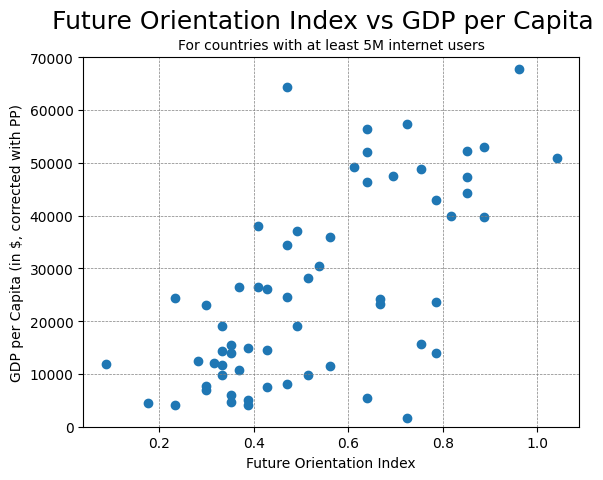

In [13]:
import matplotlib.pyplot as plt
plt.scatter(combined_df["FOI"], combined_df["gdp_cap_pp"])
plt.ylim(0, 70000)
plt.suptitle("Future Orientation Index vs GDP per Capita", fontsize = 18)
plt.title("For countries with at least 5M internet users", fontsize = 10)
plt.ylabel("GDP per Capita (in $, corrected with PP)")
plt.xlabel("Future Orientation Index")
plt.grid(color = "gray", linestyle= "--", linewidth= 0.5)
plt.show()

#### 3.2 Measure Pearson’s correlation

In the following chunk, calculate Pearson’s correlation coefficient between GDP and FOI.

For this you can use the [`pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) method of `scipy`.

In [52]:
import scipy
print("The Peason's correlation between GDP and FOI is " + str(round(float(scipy.stats.pearsonr(combined_df["gpd_cap_pp"], combined_df["FOI"])[:][0]), 3)) + " with a p-value of " + str(round(float(scipy.stats.pearsonr(combined_df["gpd_cap_pp"], combined_df["FOI"])[:][1]), 3)) + ". This indicates a positive correlation between the GDP and FOI, therefore one would expect countries that look ahead to the future more are more successful, however since there is no causal relationship being explored here then the conclusion that economies that are doing well give people the opportunity to look ahead more is equally as valid, or maybe even a combination of the two. The p-value is significant at the 95% confidence level therefore giving reasonable plausability that this is not a spurious correlation, however the sample size of around 60 is not optimal for a Pearson correlation, generally needing at least 100 or so data points to be more accurate in its predictive power. Nevertheless, this is an interesting relationship and could be further studied, perhaps with a different method of measuring the Future Orientaion Index, although the novelty and ingenuity of this method is amazing." )


The Peason's correlation between GDP and FOI is 0.654 with a p-value of 0.0. This indicates a positive correlation between the GDP and FOI, therefore one would expect countries that look ahead to the future more are more successful, however since there is no causal relationship being explored here then the conclusion that economies that are doing well give people the opportunity to look ahead more is equally as valid, or maybe even a combination of the two. The p-value is significant at the 95% confidence level therefore giving reasonable plausability that this is not a spurious correlation, however the sample size of around 60 is not optimal for a Pearson correlation, generally needing at least 100 or so data points to be more accurate in its predictive power. Nevertheless, this is an interesting relationship and could be further studied, perhaps with a different method of measuring the Future Orientaion Index, although the novelty and ingenuity of this method is amazing.


### To learn more
#### Check robustness
* What result do you get if you use other years? What if you choose one of the earliest years in Google trends?
* How do results change if you use a different threshod instead of 5 Million Internet users?
    
#### Test other hypotheses
* Is future orientation generating wealth? Or is wealth enabling to look more to the future?
* Is the FOI really measuring orientation to the future? Could it be something else?

## Part 2
## Using Google Trends data to model Flu Trends

### Install requirements. 

In [12]:
! pip install -U pytrends
! pip install requests
! pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Exercise 4 *(4 points)*
Use the [pytrends module](https://pypi.org/project/pytrends/) to get weekly Google Trends data concerning the [Flu/Influenza](https://en.wikipedia.org/wiki/Influenza) virus from the beginning of 2014 until the end of 2018. 
<br>

- Create an instance of the `TrendReq` class
- Find the appropriate query term. The TrendReq class includes a method `suggestions`, which should help you in this task (the query term can look like e.g. `/m/03x_m3v`).
- Specify the correct geographical region, the timeframe, and the key-word list. Use the `build_payload` method to store this information for future requests.
- Use the `interest_over_time` method to get the data.
<br><br>

***Hint:*** *the pytrends module currently has a bug. If you get a `TooManyRequestsError` despite following the documentation, try following the advice outlined [here](https://github.com/GeneralMills/pytrends/issues/573#issuecomment-1501897119) or [here](https://github.com/GeneralMills/pytrends/issues/561#issuecomment-1462899426) (both solve the issue).*

[{'mid': '/m/0cycc', 'title': 'Influenza', 'type': 'Disease'}, {'mid': '/m/0292d3', 'title': 'Avian influenza', 'type': 'Disease'}, {'mid': '/m/057c6k', 'title': 'Swine influenza', 'type': 'Disease'}, {'mid': '/m/0416v7', 'title': 'Influenza vaccine', 'type': 'Vaccine'}, {'mid': '/g/11c5brjhms', 'title': 'The Book You Wish Your Parents Had Read: (And Your Children Will Be Glad That You Did)', 'type': 'Book by Philippa Perry'}]


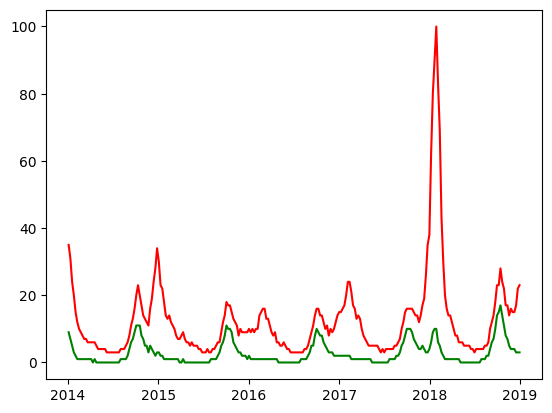

In [1]:
from pytrends.request import TrendReq
import requests
import matplotlib.pyplot as plt


session = requests.Session()
session.get('https://trends.google.com')
cookies_map = session.cookies.get_dict()
nid_cookie = cookies_map['NID']

pytrends = TrendReq(hl='en-US', tz=360, requests_args={'headers': {'Cookie': f'NID={nid_cookie}'}})
print(pytrends.suggestions("Influenza"))
# the first one is Influenza, second Influenza vaccine, tried a couple other keywords but basically 0 and had different trends
kw_list = ["/m/0cycc", "/m/0416v7"]
pytrends.build_payload(kw_list = kw_list, timeframe='2014-01-01 2018-12-31', geo='US')
g_flu = pytrends.interest_over_time()

# looking at the data, the huge spike at 2018 is because of the really bad strain in that winter where lots of 
# people got infected and there was hysteria downside of Google Trends data, people very reactive or possibly want to see 
# the latest on the flu like during COVID when we were all looking at the numbers and restrictions everyday
plt.plot(g_flu.index, g_flu["/m/0cycc"], 'r')
plt.plot(g_flu.index, g_flu["/m/0416v7"], 'g')
plt.show()


g_flu['average_volume'] = (g_flu['/m/0416v7'] + g_flu['/m/0cycc']) / 2
g_flu["total_volume"] = g_flu['/m/0416v7'] + g_flu['/m/0cycc']

### Exercise 5 *(2 points)*

In the `a01` folder you will find a file named `ILINet.csv`, which contains data regarding the occurance of Influenza like Illnesses in the US. You can also find the data and the corresponding [documentation](https://gis.cdc.gov/grasp/fluview/FluViewPhase2QuickReferenceGuide.pdf) on the CDC's [FluView interactive dashboard](https://gis.cdc.gov/grasp/fluview/fluportaldashboard.html).
<br>
- Read the csv file, and store it as a [pandas](https://pypi.org/project/pandas/) dataframe. You might need to use the `skiprows` argument of the `read_csv` method to be able to load the data correctly.
- Select the columns named `YEAR`, `WEEK`, and `% WEIGHTED ILI` which will be needed for our analysis. Additionally, drop the rows which store observations from before 2014, or after 2018.

In [12]:
import pandas as pd
ilinet_df = pd.read_csv("ILINet.csv", skiprows=1)
sel_ilinet_df = ilinet_df.loc[(ilinet_df["YEAR"] > 2013) & (ilinet_df["YEAR"] < 2019), ["YEAR", "WEEK", "% WEIGHTED ILI"]].reset_index(drop=True)

# the dates were wrong, as there were only 52 weeks in 2014, not 53, 
# so the one week was added to 2015 which did have 53 weeks and all other weeks in 2015 were shifted one
# before I decided to copy the index of the other dataframe
# sel_ilinet_df.loc[sel_ilinet_df["YEAR"] == 2015, 'WEEK'] = sel_ilinet_df["WEEK"] + 1
# sel_ilinet_df.loc[52, "YEAR"] = 2015
# sel_ilinet_df.loc[52, "WEEK"] = 1

sel_ilinet_df["DATE"] = g_flu.index
sel_ilinet_df = sel_ilinet_df.set_index('DATE')

            YEAR  WEEK  % WEIGHTED ILI
DATE                                  
2014-01-05  2014     1         4.28195
2014-01-12  2014     2         3.56288
2014-01-19  2014     3         3.36378
2014-01-26  2014     4         3.39659
2014-02-02  2014     5         3.11922
...          ...   ...             ...
2018-12-02  2018    48         2.14883
2018-12-09  2018    49         2.25531
2018-12-16  2018    50         2.64571
2018-12-23  2018    51         3.14075
2018-12-30  2018    52         3.97127

[261 rows x 3 columns]


### Exercise 6 *(6 points)*

Next, we will use the [statsmodels](https://www.statsmodels.org/stable/index.html) module to build some models which can predict Flu infections. 
<br>
- Create an [autoregressive model](https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html) using `% WEIGHTED ILI` as a dependent variable and it's [lagged](https://ibf.org/knowledge/glossary/lagged-dependent-variable-156) versions as explanatory variables. You are free to use as many lags as possible to find the best fitting model, as measured by the [Bayesian Information Criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
- You may also add [trend](https://towardsdatascience.com/understanding-time-series-trend-addfd9d7764e) and/or [seasonal](https://towardsdatascience.com/seasonality-of-time-series-5b45b4809acd) variables to the model to improve your model's fit.
- Create another model with `% WEIGHTED ILI` as a dependent variable and the Google Trend volume from the same week as the explanatory variable.
- Last, create a model which uses both the lagged values of `% WEIGHTED ILI` and the Google Trends data (and/or its lagged versions) as explanatory variables to achieve the best fit. 
- Create a linechart showing the real values of `% WEIGHTED ILI` as well as the values predicted by all three models. Discuss your results.

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
import math
import matplotlib.pyplot as plt

# short name for series
ilinet = sel_ilinet_df["% WEIGHTED ILI"]
# checking what the best lag is, used the log number of observations as cutoff but ever increasing max doesn't change result
optimal_lags_ili = ar_select_order(ilinet, int(math.log(len(ilinet))), seasonal = True, period = 52)
# AR(2) shown to be the best
optimal_lags_ili.ar_lags
# testing for unit root, if the null hypothesis is true then most likely unit root present then non-stationary meaning a time trend,
# however this is rejected at 5% and even 1% therefore not a unit root and no time trend (thankfully)
adfuller(ilinet, maxlag = 2, autolag = "BIC", regresults = True)
# keep to 2 lags, add a seasonal component for weeks of the year
result_ili = AutoReg(ilinet, lags=2, seasonal=True, period=52).fit()
# show all info about model
result_ili.summary()


# not completely sure what the second model is supposed to be, I have definitely misunderstood the task
# plt.plot(g_flu["total_volume"], ilinet, 'r')
# plt.plot(g_flu["average_volume"], ilinet, 'g')
# plt.show()



# I chose to use an ARDL model to have the weighted ili as the endogenous variable and the total Google Trends 
# data as the exogenous variable. As above I wanted to find the best model with the tools given, but keep getting 
# a weird error that I've tried to fix for an hour. 
#sel_best_combi = ardl_select_order(ilinet, 7, g_flu["total_volume"], 7, seasonal = True, period = 52, glob = True)
#combi_res = sel_best_combi.model.fit()
# this is what an ARDL model would look like if it worked
#combi_model = ARDL(ilinet, 3, g_flu["total_volume"], 2, seasonal=True, period = 52)





/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


IndexError: tuple index out of range

### To learn more
#### p-Hacking
* Try downloading data for other queries to see if you can improve the fit of your model.
    
#### Prediction
* Download the Google Trends data for 2019, and use your models to predict the values of `% WEIGHTED ILI`. Do the models make good predictions? Which model performs better?